<a href="https://colab.research.google.com/github/matsunagalab/lecture_ML/blob/main/machine_learning_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7回 識別その3: 決定木とアンサンブル学習

## iris data set を 決定木(decision tree)で識別

AUC: 0.912396480331263


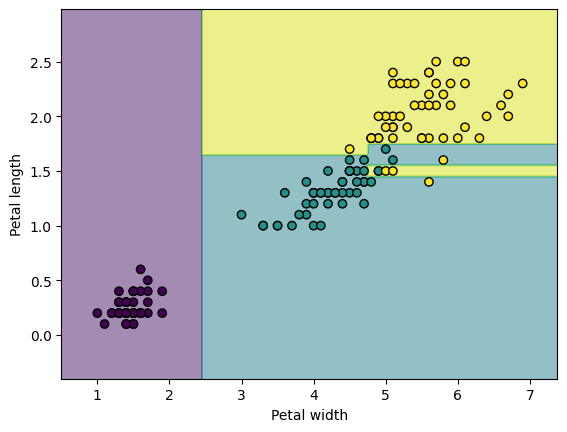

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# load iris data
iris = load_iris()
X = iris.data
y = iris.target

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# create instance of decision tree
model = DecisionTreeClassifier(criterion='gini', random_state=123)

# train the model
model.fit(X_train, y_train)

# make prediction
y_pred_proba = model.predict_proba(X_test)

# evaluate the prediction AUC
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("AUC:", auc)

# visualize decision boundary
# ranges of Petal width and Petal length
petal_width_min, petal_width_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
petal_length_min, petal_length_max = X[:, 3].min() - 0.5, X[:, 3].max() + 0.5

# create mesh grids
petal_width, petal_length = np.meshgrid(
    np.arange(petal_width_min, petal_width_max, 0.02),
    np.arange(petal_length_min, petal_length_max, 0.02)
)

# make predictions on the mesh grid
Z = model.predict(np.c_[np.full(petal_width.ravel().shape, X[:, 0].mean()),
                         np.full(petal_width.ravel().shape, X[:, 1].mean()),
                         petal_width.ravel(),
                         petal_length.ravel()])

# visualize the predictions
Z = Z.reshape(petal_width.shape)
plt.contourf(petal_width, petal_length, Z, alpha=0.5)
plt.scatter(X[:, 2], X[:, 3], c=y, edgecolors='k')
plt.xlabel('Petal width')
plt.ylabel('Petal length')
plt.show()

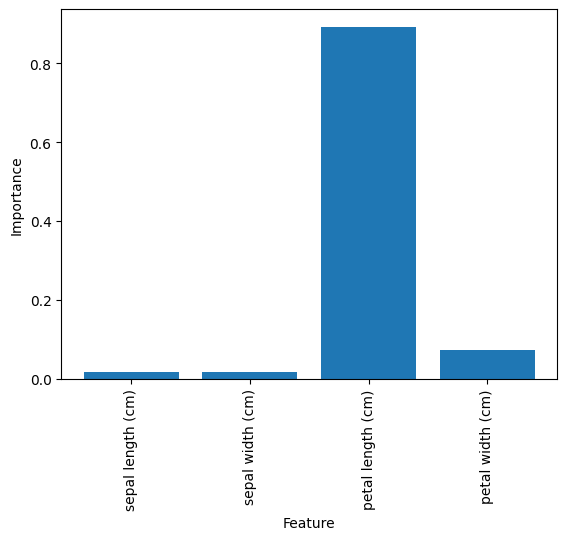

In [5]:
# visualize feature importance
import matplotlib.pyplot as plt

# get the feature importance
importance = model.feature_importances_

# plot the feature importance
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), iris.feature_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## iris data set を random forestで識別

AUC: 0.9982207556935818


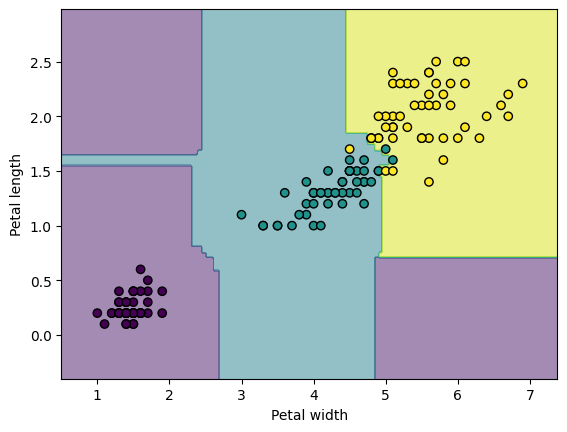

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# load iris data
iris = load_iris()
X = iris.data
y = iris.target

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# create instance of Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=123)

# train the model
model.fit(X_train, y_train)

# make prediction
y_pred_proba = model.predict_proba(X_test)

# evaluate the prediction AUC
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("AUC:", auc)

# visualize decision boundary
# ranges of Petal width and Petal length
petal_width_min, petal_width_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
petal_length_min, petal_length_max = X[:, 3].min() - 0.5, X[:, 3].max() + 0.5

# create mesh grid
petal_width, petal_length = np.meshgrid(
    np.arange(petal_width_min, petal_width_max, 0.02),
    np.arange(petal_length_min, petal_length_max, 0.02)
)

# make predictions on the mesh grid
Z = model.predict(np.c_[np.full(petal_width.ravel().shape, X[:, 0].mean()),
                         np.full(petal_width.ravel().shape, X[:, 1].mean()),
                         petal_width.ravel(),
                         petal_length.ravel()])

# visualize the predictions
Z = Z.reshape(petal_width.shape)
plt.contourf(petal_width, petal_length, Z, alpha=0.5)
plt.scatter(X[:, 2], X[:, 3], c=y, edgecolors='k')
plt.xlabel('Petal width')
plt.ylabel('Petal length')
plt.show()

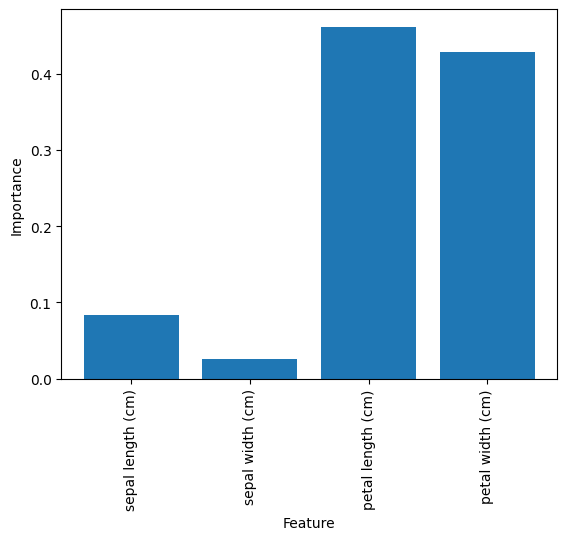

In [7]:
# visualize feature importance
import matplotlib.pyplot as plt

# get the feature importance
importance = model.feature_importances_

# plot the feature importance
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), iris.feature_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## iris data setを勾配ブースティング法(XGBoost)で識別

XGBoostはパラメータがたくさんあって、人間が適切なパラメータを選ぶのが難しいので、Optunaというパッケージでうまくいくつかのパラメータで試行錯誤してもらい適切なものを選んでもらうようにします

In [8]:
# Install XGBoost and Optuna
!pip install xgboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import optuna

# load iris data
iris = load_iris()
X, y = iris.data, iris.target

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95)
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    return auc

# tune hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# print the best parameters and score
print("Best parameters:", study.best_params)
print("Best AUC score:", study.best_value)

# train and evaluate the model with the best parameters
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# get feature importance
importance = best_model.feature_importances_
for feature, score in zip(iris.feature_names, importance):
    print(f'Feature: {feature}, Score: {score:.5f}')

# evaluate the prediction AUC
y_pred_proba = best_model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC: {auc:.2f}")

[I 2024-06-02 02:18:03,617] A new study created in memory with name: no-name-266dccf8-8fe6-4a89-80ef-f9fb4638865c
[I 2024-06-02 02:18:07,819] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 922, 'max_depth': 7, 'learning_rate': 0.03901182673160482, 'subsample': 0.6842741340720053, 'colsample_bytree': 0.688863853567904}. Best is trial 0 with value: 1.0.
[I 2024-06-02 02:18:09,993] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 614, 'max_depth': 4, 'learning_rate': 0.0011652538466656573, 'subsample': 0.9177514706283946, 'colsample_bytree': 0.6061376522539262}. Best is trial 0 with value: 1.0.
[I 2024-06-02 02:18:10,786] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 586, 'max_depth': 9, 'learning_rate': 0.09131834804605725, 'subsample': 0.7272381125590973, 'colsample_bytree': 0.7019910347429155}. Best is trial 0 with value: 1.0.
[I 2024-06-02 02:18:11,020] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 748, 'max_d

Best parameters: {'n_estimators': 922, 'max_depth': 7, 'learning_rate': 0.03901182673160482, 'subsample': 0.6842741340720053, 'colsample_bytree': 0.688863853567904}
Best AUC score: 1.0
Feature: sepal length (cm), Score: 0.10097
Feature: sepal width (cm), Score: 0.07469
Feature: petal length (cm), Score: 0.45786
Feature: petal width (cm), Score: 0.36647
AUC: 1.00


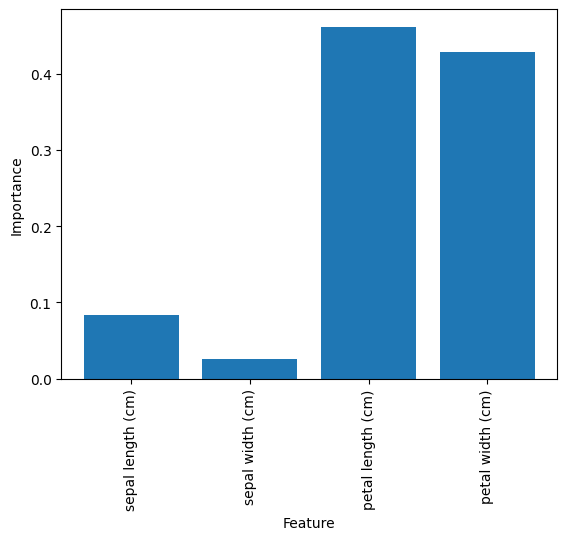

In [10]:
# visualize feature importance
import matplotlib.pyplot as plt

# get the feature importance
importance = model.feature_importances_

# plot the feature importance
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), iris.feature_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## MNIST data setを勾配ブースティング法(XGBoost)で識別

In [11]:
import xgboost as xgb
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import optuna

# load digits data
digits = load_digits()
X, y = digits.data, digits.target

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the objective function for optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95)
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    return auc

# tune hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# print the best parameters and score
print("Best parameters:", study.best_params)
print("Best AUC score:", study.best_value)

# train and evaluate the model with the best parameters
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# evaluate the prediction AUC
y_pred_proba = best_model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC: {auc:.2f}")

[I 2024-06-02 02:20:02,448] A new study created in memory with name: no-name-a80c9302-8228-4845-a920-81487e262585
[I 2024-06-02 02:20:15,324] Trial 0 finished with value: 0.9988975050528301 and parameters: {'n_estimators': 557, 'max_depth': 8, 'learning_rate': 0.0010502495571959318, 'subsample': 0.9188710679738208, 'colsample_bytree': 0.6405510662525113}. Best is trial 0 with value: 0.9988975050528301.
[I 2024-06-02 02:20:20,632] Trial 1 finished with value: 0.9997323472489713 and parameters: {'n_estimators': 866, 'max_depth': 7, 'learning_rate': 0.055267812672027135, 'subsample': 0.8822959342848544, 'colsample_bytree': 0.849231743749921}. Best is trial 1 with value: 0.9997323472489713.
[I 2024-06-02 02:20:24,594] Trial 2 finished with value: 0.9993300975699227 and parameters: {'n_estimators': 509, 'max_depth': 10, 'learning_rate': 0.004693710041659329, 'subsample': 0.6396986846921195, 'colsample_bytree': 0.8447030543234791}. Best is trial 1 with value: 0.9997323472489713.
[I 2024-06-0

Best parameters: {'n_estimators': 570, 'max_depth': 9, 'learning_rate': 0.09912463056828577, 'subsample': 0.8918309056776987, 'colsample_bytree': 0.8338330668431285}
Best AUC score: 0.999750555188965
AUC: 1.00


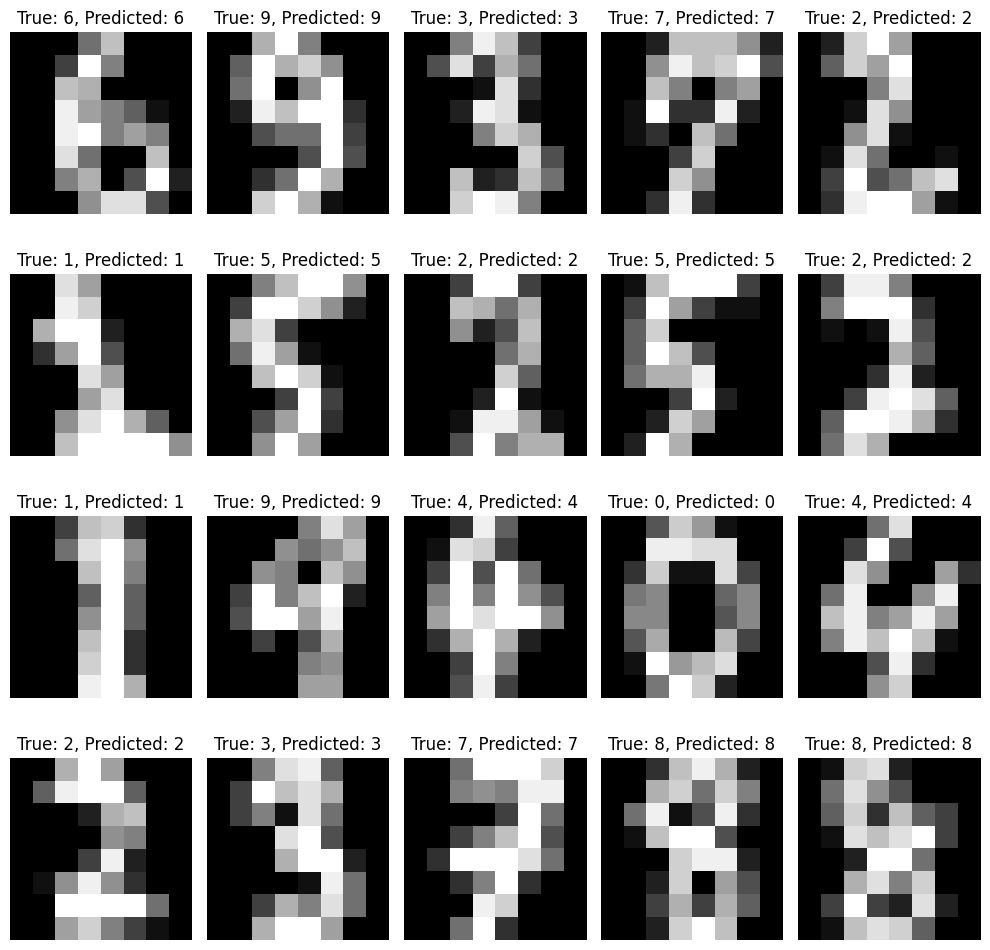

In [13]:
# show prediction and labels with images
import matplotlib.pyplot as plt

# get predictions on test data
y_pred = best_model.predict(X_test)

# select first 20 images from the test data
images = X_test[:20]
predicted_labels = y_pred[:20]
true_labels = y_test[:20]

# plot the images and their predicted labels
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].reshape((8, 8)), cmap='gray')
    plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()